In [355]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
import numpy as np
import scanpy as sc
import os
from util import normalize_rows, mse, expected_sqrt, expected_log1p

from sklearn.utils.extmath import randomized_svd

# Downsampling Deeply Sequenced Cells

In [366]:
downsample_to = 3000
min_counts_per_gene = 500

In [367]:
data_file = '/Users/josh/src/noise2self-single-cell/data/hca/hca_marrow_deep.h5ad'
#data_file = '/Users/josh/src/noise2self-single-cell/data/neurons/neurons_deep.h5ad'
data = sc.read(data_file)

In [368]:
sc.pp.filter_genes(data, min_counts=min_counts_per_gene)
data_down = sc.pp.downsample_counts(data, downsample_to, replace = False, copy = True)

In [369]:
x = np.array(data_down.X.todense())

In [370]:
x1 = np.random.binomial(x, 0.5)
x2 = x - x1

If we have GT, then we can compute the expected output, ie, the ground-truth.

In [371]:
y = np.array(data.X.todense())
mean = y/y.sum(axis = 1, keepdims = True) * downsample_to/2
z = expected_sqrt(mean)

## Load Simulation

In [364]:
import pickle
with open('/Users/josh/src/noise2self-single-cell/data/sim/dataset_0.pickle', 'rb') as fp:
    exp, class_labels, programs, lib_size, umis_X, umis_Y = pickle.load(fp)
mean = np.exp(exp.dot(programs))
x1 = umis_X
x2 = umis_Y

counts = (umis_X + umis_Y).sum(axis = 1, keepdims = True)/2
mean = mean/mean.sum(axis = 1, keepdims = True) * counts

## PCA: Square root

In [373]:
max_k = 20

x1_norm = np.sqrt(x1)
x2_norm = np.sqrt(x2)

U, S, V = randomized_svd(x1_norm, n_components=50, random_state=42)

ae_loss_pca_mse = []
ss_loss_pca_mse = []
gt_loss_pca_mse = []
k_range = np.arange(1, max_k)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ae_loss_pca_mse.append(mse(x_pred, x1_norm))
    ss_loss_pca_mse.append(mse(x_pred, x2_norm))
    gt_loss_pca_mse.append(mse(x_pred, z))
k_opt = k_range[np.argmin(ss_loss_pca_mse)]
                
print(k_opt)

9


Text(0.5,0,'Principal Components')

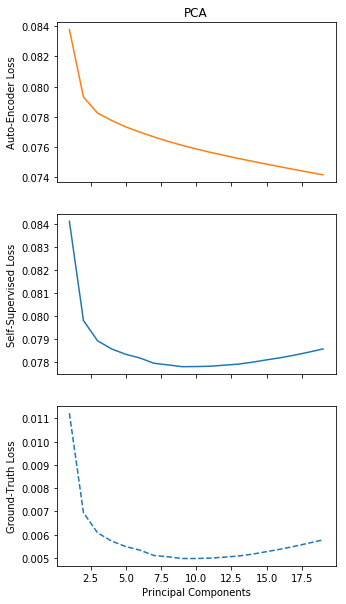

In [374]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(k_range, ae_loss_pca_mse, color = 'C1')
ax0.set_title("PCA")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(k_range, ss_loss_pca_mse)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(k_range, gt_loss_pca_mse, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

In [375]:
# Check that we have a fixed relationship w gt loss
# np.array(ss_loss_pca_mse) - np.array(gt_loss_pca_mse)

In [376]:
print("Min GT Loss: ", np.min(gt_loss_pca_mse))

Min GT Loss:  0.0049680426734804075


# Diffusion

In [426]:
lazy_p = 0.25
max_t = 10

In [427]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [428]:
import magic
def compute_diff_op(x, lazy_p = 0, method = 'magic'):
    median_counts = np.median(x.sum(axis=1)) / 2

    X = np.sqrt(normalize_rows(x, median_counts))

    if method == 'magic':
        magic_op = magic.MAGIC()
        magic_op.fit(X)
        diff_op = np.array(magic_op.diff_op.todense())
    elif method == 'knn':
        U, S, _ = randomized_svd(X, 30)
        X = U.dot(np.diag(S))
        nbrs = NearestNeighbors(n_neighbors=15).fit(X)
        diff_op = nbrs.kneighbors_graph(X, mode='connectivity')
        diff_op = np.array(diff_op.todense())
        diff_op = diff_op + diff_op.T
        diff_op = diff_op/diff_op.sum(axis = 1, keepdims = True)
    else:
        raise NotImplementedError

    diff_op = (1 - lazy_p) * diff_op + lazy_p * np.eye(diff_op.shape[0])
    return diff_op

In [429]:
diff_op = compute_diff_op(x1, lazy_p = lazy_p, method='knn')

In [430]:
x1_norm = np.sqrt(x1)
x2_norm = np.sqrt(x2)

denoised = x1_norm.copy()
ss_loss_diffusion_mse, gt_loss_diffusion_mse, ae_loss_diffusion_mse = [], [], []

t_range = np.arange(max_t)

for t in t_range:
    ae_loss_diffusion_mse.append(mse(denoised, x1_norm))
    ss_loss_diffusion_mse.append(mse(denoised, x2_norm))
    gt_loss_diffusion_mse.append(mse(denoised, z))
#    print(2*((denoised - z)*(z - x2_norm)).mean())
    denoised = diff_op.dot(denoised)

Text(0.5,0,'Diffusion Time')

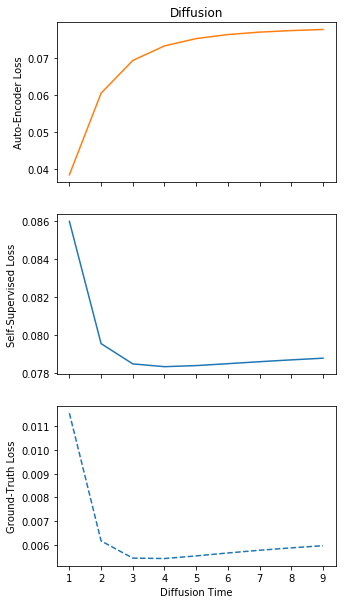

In [431]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(t_range[1:], ae_loss_diffusion_mse[1:], color = 'C1')
ax0.set_title("Diffusion")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(t_range[1:], ss_loss_diffusion_mse[1:])
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(t_range[1:], gt_loss_diffusion_mse[1:], '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')

In [432]:
print("Min GT Loss: ", np.min(gt_loss_diffusion_mse))

Min GT Loss:  0.005421743427401438


In [433]:
print("Min GT Loss: ", np.min(gt_loss_diffusion_mse[np.argmin(ss_loss_diffusion_mse)]))

Min GT Loss:  0.005421743427401438


# Plot Ensemble

Text(0.5,0,'Diffusion Time')

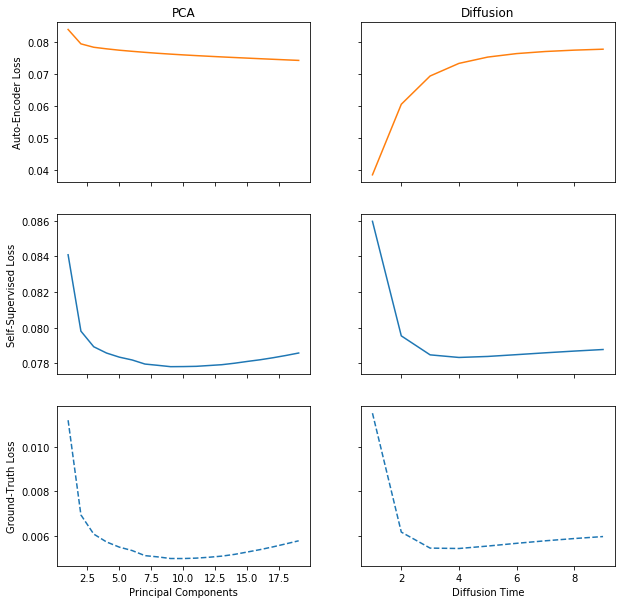

In [437]:
fig, ax = plt.subplots(3, 2, sharex = 'col', sharey='row', figsize=(10,10))

ax[0,0].plot(k_range, ae_loss_pca_mse, color = 'C1')
ax[0,0].set_title("PCA")
ax[0,0].set_ylabel('Auto-Encoder Loss')

ax[1,0].plot(k_range, ss_loss_pca_mse)
ax[1,0].set_ylabel('Self-Supervised Loss')
ax[2,0].plot(k_range, gt_loss_pca_mse, '--')
ax[2,0].set_ylabel('Ground-Truth Loss')
ax[2,0].set_xlabel('Principal Components')

init_time = 1
ax[0,1].plot(t_range[init_time:], ae_loss_diffusion_mse[init_time:], color = 'C1')
ax[0,1].set_title("Diffusion")

ax[1,1].plot(t_range[init_time:], ss_loss_diffusion_mse[init_time:])
ax[2,1].plot(t_range[init_time:], gt_loss_diffusion_mse[init_time:], '--')
ax[2,1].set_xlabel('Diffusion Time')

## Poisson Diffusion

In [442]:
# Negative log likelihood
def poisson_log_lik(lam, k, per_gene = False):
    if per_gene:
        return (lam - k*np.log(lam)).mean(axis = 0)
    else:
        return (lam - k*np.log(lam)).mean()

In [446]:
denoised = x1.copy()

ss_loss_diffusion_poisson, gt_loss_diffusion_poisson, ae_loss_diffusion_poisson = [], [], []

for i in range(max_t):    
    ae_loss_diffusion_poisson.append(poisson_log_lik(denoised + 1e-3, x1))
    ss_loss_diffusion_poisson.append(poisson_log_lik(denoised + 1e-3, x2))
    gt_loss_diffusion_poisson.append(poisson_log_lik(denoised + 1e-3, mean))

    denoised = diff_op.dot(denoised)

In [444]:
np.argmin(ss_loss), np.argmin(gt_loss)

(5, 5)

Text(0.5,0,'Diffusion Time')

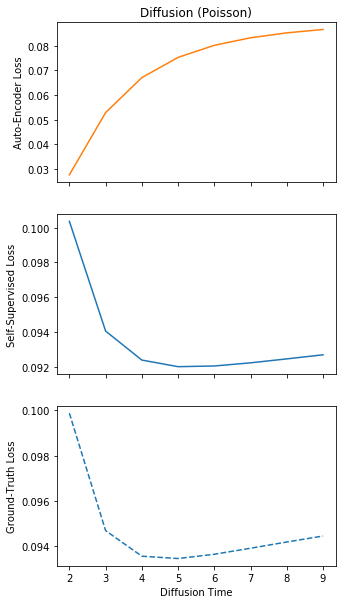

In [451]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

init_time = 2

ax0.plot(t_range[init_time:], ae_loss_diffusion_poisson[init_time:], color = 'C1')
ax0.set_title("Diffusion (Poisson)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(t_range[init_time:], ss_loss_diffusion_poisson[init_time:])
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(t_range[init_time:], gt_loss_diffusion_poisson[init_time:], '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')